# Small Dataset CV Project

1. Small CNN model trained with available dataset: total trainable parameters = 63 million, optimal val_mape = 8.4 (Epoch 13) or 5.4 within 100 Epochs.
2. Feature Extraction with pre-trained Efficient Net B0: total trainable parameters = 6403, optimal val_mape = 8.93 (Epoch 4)
3. Fine-tuning a Chest x-ray pre-trained Model: total trainable parameters = 15.2 million, optimal val_mape =  (Epoch )
4. Optimal Val_mape is achieved with 20 epochs.
5. mean baseline MAPEs:  8.867852813949915 10.000738559848955 8.017046376840236, average: 8.962 (bigger than this number is bad)

Traing images: 196,
Validation images: 57,
Test images: 29.

Images are resized as 512x512:

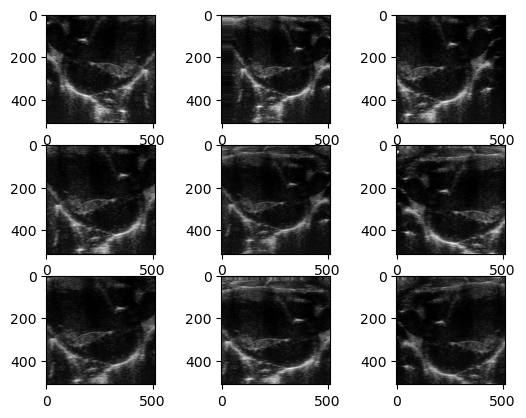


## Load and fine-tune the x-ray trained model
## Freeze Conv layers, rebuild the output layer and re-train top layers

In [1]:
# import tensorflow as tf
# base_model= tf.keras.models.load_model('tl_ft_cnn.keras')
# model_config = base_model.get_config()
# model_config["layers"][0]["config"]["batch_input_shape"] = (None, 512, 512, 3)
# x_model = tf.keras.Model.from_config(model_config)

# # Freeze all the layers before the `fine_tune_at` layer and optionally this number should be optimized.
# for layer in x_model.layers[:-10]:  #re-train two conv layers on the top
#     layer.trainable = False
    
# modified_model = tf.keras.models.Sequential()
# for layer in x_model.layers[:-1]: # go through until last layer
#     modified_model.add(layer)

# modified_model.add(tf.keras.layers.Dense(3, name="Output_Layer"))

In [2]:
import pandas as pd
import os
# file_list = []
# for file in os.listdir('testinput'):
#     if file.endswith('.png'):
#         file_list.append(file)
# df = pd.DataFrame({'Filename': file_list})
# df['Co1']=df.Filename.str[0:3]
# df['Co2']=df.Filename.str[4:7]
# df['Co3']=df.Filename.str[8:11]
# df['ID']=df.Filename.str[0:11]
# df = df.astype({'Co1': 'float', 'Co2': 'float', 'Co3': 'float'})
# df.to_pickle(f"df.pkl")

In [3]:
df = pd.read_pickle("df.pkl")

In [4]:
df

,Filename,Co1,Co2,Co3,ID
0,"272,323,475.png",272.0,323.0,475.0,"272,323,475"
1,"273,331,471.png",273.0,331.0,471.0,"273,331,471"
2,"277,258,383.png",277.0,258.0,383.0,"277,258,383"
3,"279,208,316.png",279.0,208.0,316.0,"279,208,316"
4,"292,266,395.png",292.0,266.0,395.0,"292,266,395"
...,...,...,...,...,...
277,"477,351,482.png",477.0,351.0,482.0,"477,351,482"
278,"489,314,450.png",489.0,314.0,450.0,"489,314,450"
279,"494,355,492.png",494.0,355.0,492.0,"494,355,492"
280,"500,323,486.png",500.0,323.0,486.0,"500,323,486"


## CNN Model Training

In [5]:
from typing import Iterator, List, Union, Tuple, Any
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model
from tensorflow.python.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanAbsoluteError, MeanAbsolutePercentageError
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import History

# the next 3 lines of code are for my machine and setup due to https://github.com/tensorflow/tensorflow/issues/43174
import tensorflow as tf

#physical_devices = tf.config.list_physical_devices("GPU")
#tf.config.experimental.set_memory_growth(physical_devices[0], True)


def visualize_augmentations(data_generator: ImageDataGenerator, df: pd.DataFrame):
    """Visualizes the keras augmentations with matplotlib in 3x3 grid. This function is part of create_generators() and
    can be accessed from there.

    Parameters
    ----------
    data_generator : Iterator
        The keras data generator of your training data.
    df : pd.DataFrame
        The Pandas DataFrame containing your training data.
    """
    # super hacky way of creating a small dataframe with one image
    series = df.iloc[2]

    df_augmentation_visualization = pd.concat([series, series], axis=1).transpose()

    iterator_visualizations = data_generator.flow_from_dataframe(  # type: ignore
        dataframe=df_augmentation_visualization,
        x_col="image_location",
        y_col=["Co1","Co2","Co3"],
        class_mode="raw",
        target_size=(512, 512),  # size of the image
        batch_size=1,  # use only one image for visualization
    )

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)  # create a 3x3 grid
        batch = next(iterator_visualizations)  # get the next image of the generator (always the same image)
        img = batch[0]  # type: ignore
        img = img[0, :, :, :]  # remove one dimension for plotting without issues
        plt.imshow(img)
    plt.show()
    plt.close()


def get_mean_baseline(train: pd.DataFrame, val: pd.DataFrame) -> float:
    """Calculates the mean MAE and MAPE baselines by taking the mean values of the training data as prediction for the
    validation target feature.

    Parameters
    ----------
    train : pd.DataFrame
        Pandas DataFrame containing your training data.
    val : pd.DataFrame
        Pandas DataFrame containing your validation data.

    Returns
    -------
    float
        MAPE value.
    """
    y_hat1 = train["Co1"].mean()
    y_hat2 = train["Co2"].mean()
    y_hat3 = train["Co3"].mean()
    val["y_hat1"] = y_hat1
    val["y_hat2"] = y_hat2
    val["y_hat3"] = y_hat3
    mae = MeanAbsoluteError()
    mae1 = mae(val["Co1"], val["y_hat1"]).numpy()
    mae2 = mae(val["Co2"], val["y_hat2"]).numpy()
    mae3 = mae(val["Co3"], val["y_hat3"]).numpy()    # type: ignore
    mape = MeanAbsolutePercentageError()
    mape1 = mape(val["Co1"], val["y_hat1"]).numpy()
    mape2 = mape(val["Co2"], val["y_hat2"]).numpy()
    mape3 = mape(val["Co3"], val["y_hat3"]).numpy()   # type: ignore

    print(mae1, mae2, mae3)
    print("mean baseline MAPEs: ", mape1, mape2, mape3)

    return np.array([mape1,mape2,mape3])


def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Accepts a Pandas DataFrame and splits it into training, testing and validation data. Returns DataFrames.

    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.

    Returns
    -------
    Union[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        [description]
    """
    train, val = train_test_split(df, test_size=0.2, random_state=1)  # split the data with a validation size o 20%
    train, test = train_test_split(
        train, test_size=0.1, random_state=1
    )  # split the data with an overall  test size of 10%

    print("shape train: ", train.shape)  # type: ignore
    print("shape val: ", val.shape)  # type: ignore
    print("shape test: ", test.shape)  # type: ignore

    print("Descriptive statistics of train:")
    print(train.describe())  # type: ignore
    return train, val, test  # type: ignore


def create_generators(
    df: pd.DataFrame, train: pd.DataFrame, val: pd.DataFrame, test: pd.DataFrame, plot_augmentations: Any
) -> Tuple[Iterator, Iterator, Iterator]:
    """Accepts four Pandas DataFrames: all your data, the training, validation and test DataFrames. Creates and returns
    keras ImageDataGenerators. Within this function you can also visualize the augmentations of the ImageDataGenerators.

    Parameters
    ----------
    df : pd.DataFrame
        Your Pandas DataFrame containing all your data.
    train : pd.DataFrame
        Your Pandas DataFrame containing your training data.
    val : pd.DataFrame
        Your Pandas DataFrame containing your validation data.
    test : pd.DataFrame
        Your Pandas DataFrame containing your testing data.

    Returns
    -------
    Tuple[Iterator, Iterator, Iterator]
        keras ImageDataGenerators used for training, validating and testing of your models.
    """
    train_generator = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        brightness_range=(0.75, 1),
        shear_range=0.1,
        zoom_range=[0.75, 1],
        horizontal_flip=True,
        validation_split=0.2,
    )  # create an ImageDataGenerator with multiple image augmentations
    validation_generator = ImageDataGenerator(
        rescale=1.0 / 255
    )  # except for rescaling, no augmentations are needed for validation and testing generators
    test_generator = ImageDataGenerator(rescale=1.0 / 255)
    # visualize image augmentations
    if plot_augmentations == True:
        visualize_augmentations(train_generator, df)

    train_generator = train_generator.flow_from_dataframe(
        dataframe=train,
        x_col="image_location",  # this is where your image data is stored
        y_col=["Co1","Co2","Co3"],  # this is your target feature
        class_mode="raw",  # use "raw" for regressions
        target_size=(512, 512),
        batch_size=8,  # increase or decrease to fit your GPU
    )

    validation_generator = validation_generator.flow_from_dataframe(
        dataframe=val, x_col="image_location", y_col=["Co1","Co2","Co3"], class_mode="raw", target_size=(512, 512), batch_size=32,
    )
    test_generator = test_generator.flow_from_dataframe(
        dataframe=test, x_col="image_location", y_col=["Co1","Co2","Co3"], class_mode="raw", target_size=(512, 512), batch_size=32,
    )
    return train_generator, validation_generator, test_generator


def get_callbacks(model_name: str) -> List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]:
    """Accepts the model name as a string and returns multiple callbacks for training the keras model.

    Parameters
    ----------
    model_name : str
        The name of the model as a string.

    Returns
    -------
    List[Union[TensorBoard, EarlyStopping, ModelCheckpoint]]
        A list of multiple keras callbacks.
    """
    logdir = (
        "logs/scalars/" + model_name + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    )  # create a folder for each model.
    #    tensorboard_callback = TensorBoard(log_dir=logdir)
    # use tensorboard --logdir logs/scalars in your command line to startup tensorboard with the correct logs

    early_stopping_callback = EarlyStopping(
        monitor="val_mean_absolute_percentage_error",
        min_delta=1,  # model should improve by at least 1%
        patience=10,  # amount of epochs  with improvements worse than 1% until the model stops
        verbose=2,
        mode="min",
        restore_best_weights=True,  # restore the best model with the lowest validation error
    )

    model_checkpoint_callback = ModelCheckpoint(
        "./data/models/" + model_name + ".h5",
        monitor="val_mean_absolute_percentage_error",
        verbose=0,
        save_best_only=True,  # save the best model
        mode="min",
        save_freq="epoch",  # save every epoch
    )  # saving eff_net takes quite a bit of time
    #return [tensorboard_callback, early_stopping_callback, model_checkpoint_callback]
    return [early_stopping_callback, model_checkpoint_callback]

def small_cnn() -> Sequential:
    """A very small custom convolutional neural network with image input dimensions of 224x224x3.

    Returns
    -------
    Sequential
        The keras Sequential model.
    """
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(512, 512, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu"))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(3))

    return model


def run_model(
    model_name: str,
    model_function: Model,
    lr: float,
    train_generator: Iterator,
    validation_generator: Iterator,
    test_generator: Iterator,
) -> History:

    callbacks = get_callbacks(model_name)
    model = model_function
    #model.summary()
    plot_model(model, to_file=model_name + ".png", show_shapes=True)

    radam = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    optimizer = ranger

    model.compile(
        optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
    )
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=callbacks,
        workers=1,  # adjust this according to the number of CPU cores of your machine
    )

    model.evaluate(
        test_generator, callbacks=callbacks,
    )
    
    model.save('effnet.keras')
    return history  # type: ignore


def adapt_efficient_net() -> Model:
    """This code uses adapts the most up-to-date version of EfficientNet with NoisyStudent weights to a regression
    problem. Most of this code is adapted from the official keras documentation.

    Returns
    -------
    Model
        The keras model.
    """
    inputs = layers.Input(
        shape=(512, 512, 3)
    )  # input shapes of the images should always be 224x224x3 with EfficientNetB0
    # use the downloaded and converted newest EfficientNet wheights
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="efficientnetb0_notop.h5")
    # Freeze the pretrained weights
    model.trainable = False
    
    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = layers.Dense(64, name="last_dense")(x)
    outputs = layers.Dense(3, name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")

    return model


def run(small_sample=False):
    """Run all the code of this file.

    Parameters
    ----------
    small_sample : bool, optional
        If you just want to check if the code is working, set small_sample to True, by default False
    """

    df = pd.read_pickle("df.pkl")
    # modify the above file path accordingly.
    
    
    df["image_location"] = (
        "testinput/" + df["ID"] + ".png"
    )  # add the correct path for the image locations.
    
    
    if small_sample == True:
        df = df.iloc[0:1000]  # set small_sampe to True if you want to check if your code works without long waiting
    train, val, test = split_data(df)  # split your data
    mean_baseline = get_mean_baseline(train, val)
    train_generator, validation_generator, test_generator = create_generators(
        df=df, train=train, val=val, test=test, plot_augmentations=True
    )

#     small_cnn_history = run_model(
#         model_name="small_cnn",
#         model_function=small_cnn(),
#         lr=0.001,
#         train_generator=train_generator,
#         validation_generator=validation_generator,
#         test_generator=test_generator,
#     )

    eff_net_history = run_model(
        model_name="eff_net",
        model_function=adapt_efficient_net(),
        lr=0.5,
        train_generator=train_generator,
        validation_generator=validation_generator,
        test_generator=test_generator,
    )
    

    #plot_results(small_cnn_history, eff_net_history, mean_baseline)


# if __name__ == "__main__":
#     run(small_sample=False)


C:\Users\wzeng\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\wzeng\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

In [6]:
# new_model = tf.keras.models.load_model("effnet.keras", compile=False)
# new_model.trainable = False

# for layer in new_model.layers[-8:]:
#     layer.trainable = True
#     print(layer)

In [7]:
df["image_location"] = (
        "testinput/" + df["ID"] + ".png"
    )  # add the correct path for the image locations.

shape train:  (202, 6)
shape val:  (57, 6)
shape test:  (23, 6)
Descriptive statistics of train:
              Co1         Co2         Co3
count  202.000000  202.000000  202.000000
mean   385.356436  321.712871  462.648515
std     38.476092   29.938024   35.157927
min    272.000000  208.000000  316.000000
25%    359.000000  307.000000  446.000000
50%    390.500000  324.000000  471.000000
75%    411.750000  341.000000  487.000000
max    500.000000  390.000000  512.000000
Found 2 validated image filenames.


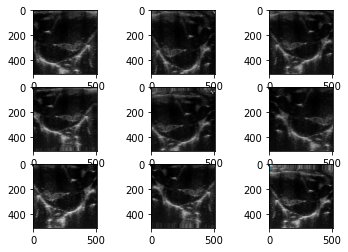

Found 202 validated image filenames.
Found 57 validated image filenames.
Found 23 validated image filenames.


In [8]:
train, val, test = split_data(df)  # split your data
train_gen, validation_gen, test_gen = create_generators(
    df=df, train=train, val=val, test=test, plot_augmentations=True
)
radam = tfa.optimizers.RectifiedAdam(learning_rate=0.1)
optimizer = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)

# new_model.compile(
#     optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
# )

# new_model.fit(
#     train_gen,
#     epochs=100,
#     validation_data=validation_gen,
#     workers=1,  # adjust this according to the number of CPU cores of your machine
# )

In [9]:
# new_model.fit(
#     train_gen,
#     epochs=63,
#     validation_data=validation_gen,
#     workers=1,  # adjust this according to the number of CPU cores of your machine
# )
# new_model.save('effnet_ft.keras')

In [10]:
# new_model2 = tf.keras.models.load_model("effnet_ft.keras", compile=False)
# new_model2.trainable = False

# for layer in new_model2.layers[-10:]:
#     layer.trainable = True
#     print(layer)

In [11]:
# new_model2.compile(
#     optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
# )

# new_model2.fit(
#     train_gen,
#     epochs=100,
#     validation_data=validation_gen,
#     workers=1,  # adjust this according to the number of CPU cores of your machine
# )

In [12]:
# new_model2.fit(
#     train_gen,
#     epochs=44,
#     validation_data=validation_gen,
#     workers=1,  # adjust this according to the number of CPU cores of your machine
# )
# new_model2.save('effnet_ft2.keras')

In [13]:
new_model3 = tf.keras.models.load_model("effnet_ft2.keras", compile=False)
new_model3.trainable = False

for layer in new_model3.layers[-18:]:
    layer.trainable = True
    print(layer)
    
new_model3.compile(
    optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
)

new_model3.fit(
    train_gen,
    epochs=100,
    validation_data=validation_gen,
    workers=1,  # adjust this according to the number of CPU cores of your machine
)

Epoch 1/100
26/26 [==============================] - 21s 462ms/step - loss: 74.6055 - mean_absolute_error: 73.8383 - mean_absolute_percentage_error: 18.9757 - val_loss: 53.6660 - val_mean_absolute_error: 53.3306 - val_mean_absolute_percentage_error: 13.3131
Epoch 2/100
26/26 [==============================] - 10s 382ms/step - loss: 70.6269 - mean_absolute_error: 70.7406 - mean_absolute_percentage_error: 18.3214 - val_loss: 36.2857 - val_mean_absolute_error: 36.9060 - val_mean_absolute_percentage_error: 9.7499
Epoch 3/100
26/26 [==============================] - 10s 374ms/step - loss: 63.8644 - mean_absolute_error: 63.5806 - mean_absolute_percentage_error: 16.3970 - val_loss: 34.7695 - val_mean_absolute_error: 35.1361 - val_mean_absolute_percentage_error: 9.7837
Epoch 4/100
26/26 [==============================] - 10s 400ms/step - loss: 66.4206 - mean_absolute_error: 65.4405 - mean_absolute_percentage_error: 16.7733 - val_loss: 33.3485 - val_mean_absolute_error: 33.4055 - val_mean_absol

26/26 [==============================] - 12s 460ms/step - loss: 67.5410 - mean_absolute_error: 68.8443 - mean_absolute_percentage_error: 17.7876 - val_loss: 88.6996 - val_mean_absolute_error: 89.0022 - val_mean_absolute_percentage_error: 22.0531
Epoch 28/100
26/26 [==============================] - 13s 495ms/step - loss: 68.1710 - mean_absolute_error: 69.1401 - mean_absolute_percentage_error: 17.8369 - val_loss: 90.8276 - val_mean_absolute_error: 91.0507 - val_mean_absolute_percentage_error: 22.5742
Epoch 29/100
26/26 [==============================] - 12s 492ms/step - loss: 66.8553 - mean_absolute_error: 65.6170 - mean_absolute_percentage_error: 16.8169 - val_loss: 87.7253 - val_mean_absolute_error: 87.9594 - val_mean_absolute_percentage_error: 21.7809
Epoch 30/100
26/26 [==============================] - 12s 455ms/step - loss: 65.5554 - mean_absolute_error: 64.5246 - mean_absolute_percentage_error: 16.6887 - val_loss: 89.8837 - val_mean_absolute_error: 89.7741 - val_mean_absolute_per

Epoch 59/100
26/26 [==============================] - 11s 424ms/step - loss: 70.1969 - mean_absolute_error: 72.3375 - mean_absolute_percentage_error: 18.6014 - val_loss: 89.3380 - val_mean_absolute_error: 90.3271 - val_mean_absolute_percentage_error: 22.3501
Epoch 60/100
26/26 [==============================] - 11s 441ms/step - loss: 70.8722 - mean_absolute_error: 72.2890 - mean_absolute_percentage_error: 18.8694 - val_loss: 89.6075 - val_mean_absolute_error: 90.0174 - val_mean_absolute_percentage_error: 22.2902
Epoch 61/100
26/26 [==============================] - 12s 448ms/step - loss: 73.9397 - mean_absolute_error: 73.4007 - mean_absolute_percentage_error: 18.9847 - val_loss: 88.4154 - val_mean_absolute_error: 88.5282 - val_mean_absolute_percentage_error: 21.9370
Epoch 62/100
26/26 [==============================] - 11s 435ms/step - loss: 68.4474 - mean_absolute_error: 68.9635 - mean_absolute_percentage_error: 17.7875 - val_loss: 88.4591 - val_mean_absolute_error: 88.0043 - val_mean

Epoch 91/100
26/26 [==============================] - 12s 442ms/step - loss: 65.3332 - mean_absolute_error: 64.6864 - mean_absolute_percentage_error: 16.7006 - val_loss: 87.6936 - val_mean_absolute_error: 86.9947 - val_mean_absolute_percentage_error: 21.5694
Epoch 92/100
26/26 [==============================] - 11s 434ms/step - loss: 67.1121 - mean_absolute_error: 66.3883 - mean_absolute_percentage_error: 17.0169 - val_loss: 88.1938 - val_mean_absolute_error: 87.8831 - val_mean_absolute_percentage_error: 21.7894
Epoch 93/100
26/26 [==============================] - 12s 449ms/step - loss: 66.0523 - mean_absolute_error: 65.3339 - mean_absolute_percentage_error: 16.7495 - val_loss: 86.9496 - val_mean_absolute_error: 87.0864 - val_mean_absolute_percentage_error: 21.5596
Epoch 94/100
26/26 [==============================] - 12s 458ms/step - loss: 68.8188 - mean_absolute_error: 67.6500 - mean_absolute_percentage_error: 17.4385 - val_loss: 87.6800 - val_mean_absolute_error: 89.1563 - val_mean

In [14]:
new_model3.fit(
    train_gen,
    epochs=71,
    validation_data=validation_gen,
    workers=1,  # adjust this according to the number of CPU cores of your machine
)
new_model3.save('effnet_ft3.keras')

Epoch 1/71
26/26 [==============================] - 11s 422ms/step - loss: 67.9295 - mean_absolute_error: 68.1314 - mean_absolute_percentage_error: 17.6133 - val_loss: 89.6583 - val_mean_absolute_error: 89.1731 - val_mean_absolute_percentage_error: 22.1032
Epoch 2/71
26/26 [==============================] - 11s 404ms/step - loss: 62.4740 - mean_absolute_error: 62.8469 - mean_absolute_percentage_error: 16.2435 - val_loss: 91.8761 - val_mean_absolute_error: 92.3183 - val_mean_absolute_percentage_error: 22.8758
Epoch 3/71
26/26 [==============================] - 10s 398ms/step - loss: 67.9698 - mean_absolute_error: 66.8518 - mean_absolute_percentage_error: 17.4637 - val_loss: 90.4257 - val_mean_absolute_error: 91.6387 - val_mean_absolute_percentage_error: 22.6872
Epoch 4/71
26/26 [==============================] - 10s 396ms/step - loss: 70.3435 - mean_absolute_error: 69.6586 - mean_absolute_percentage_error: 17.9694 - val_loss: 90.9065 - val_mean_absolute_error: 91.6699 - val_mean_absolut

Epoch 33/71
26/26 [==============================] - 11s 438ms/step - loss: 65.1998 - mean_absolute_error: 64.5003 - mean_absolute_percentage_error: 16.4973 - val_loss: 92.2370 - val_mean_absolute_error: 92.9028 - val_mean_absolute_percentage_error: 23.0343
Epoch 34/71
26/26 [==============================] - 12s 450ms/step - loss: 65.6903 - mean_absolute_error: 65.6139 - mean_absolute_percentage_error: 16.9311 - val_loss: 88.6053 - val_mean_absolute_error: 88.7803 - val_mean_absolute_percentage_error: 22.0092
Epoch 35/71
26/26 [==============================] - 12s 450ms/step - loss: 71.7667 - mean_absolute_error: 70.8904 - mean_absolute_percentage_error: 18.2091 - val_loss: 90.3417 - val_mean_absolute_error: 90.6532 - val_mean_absolute_percentage_error: 22.4572
Epoch 36/71
26/26 [==============================] - 12s 442ms/step - loss: 67.2310 - mean_absolute_error: 65.7180 - mean_absolute_percentage_error: 17.1996 - val_loss: 88.2709 - val_mean_absolute_error: 89.6143 - val_mean_abs

Epoch 65/71
26/26 [==============================] - 12s 468ms/step - loss: 65.5269 - mean_absolute_error: 65.3689 - mean_absolute_percentage_error: 16.6646 - val_loss: 87.3498 - val_mean_absolute_error: 86.6819 - val_mean_absolute_percentage_error: 21.4990
Epoch 66/71
26/26 [==============================] - 12s 463ms/step - loss: 67.2132 - mean_absolute_error: 68.3288 - mean_absolute_percentage_error: 17.7437 - val_loss: 88.6969 - val_mean_absolute_error: 88.0740 - val_mean_absolute_percentage_error: 21.8714
Epoch 67/71
26/26 [==============================] - 12s 453ms/step - loss: 63.3005 - mean_absolute_error: 62.4769 - mean_absolute_percentage_error: 16.1461 - val_loss: 88.5617 - val_mean_absolute_error: 89.0603 - val_mean_absolute_percentage_error: 22.0557
Epoch 68/71
26/26 [==============================] - 12s 448ms/step - loss: 69.5031 - mean_absolute_error: 69.4949 - mean_absolute_percentage_error: 17.7752 - val_loss: 88.3267 - val_mean_absolute_error: 88.6007 - val_mean_abs

In [15]:
new_model4 = tf.keras.models.load_model("effnet_ft3.keras", compile=False)
new_model4.trainable = False

for layer in new_model4.layers[-21:]:
    layer.trainable = True
    print(layer)
    
new_model4.compile(
    optimizer=optimizer, loss="mean_absolute_error", metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError()]
)

new_model4.fit(
    train_gen,
    epochs=100,
    validation_data=validation_gen,
    workers=1,  # adjust this according to the number of CPU cores of your machine
)

Epoch 1/100
26/26 [==============================] - 15s 447ms/step - loss: 63.8468 - mean_absolute_error: 63.6808 - mean_absolute_percentage_error: 16.3661 - val_loss: 157.4485 - val_mean_absolute_error: 157.8462 - val_mean_absolute_percentage_error: 40.0509
Epoch 2/100
26/26 [==============================] - 14s 546ms/step - loss: 62.4800 - mean_absolute_error: 64.1648 - mean_absolute_percentage_error: 16.7044 - val_loss: 152.4785 - val_mean_absolute_error: 152.3917 - val_mean_absolute_percentage_error: 38.6724
Epoch 3/100
26/26 [==============================] - 10s 401ms/step - loss: 62.3878 - mean_absolute_error: 61.4756 - mean_absolute_percentage_error: 15.8899 - val_loss: 147.8340 - val_mean_absolute_error: 148.5552 - val_mean_absolute_percentage_error: 37.5835
Epoch 4/100
26/26 [==============================] - 11s 409ms/step - loss: 64.8548 - mean_absolute_error: 65.1895 - mean_absolute_percentage_error: 16.9104 - val_loss: 145.7951 - val_mean_absolute_error: 146.1591 - val_

26/26 [==============================] - 12s 476ms/step - loss: 68.4803 - mean_absolute_error: 67.3262 - mean_absolute_percentage_error: 17.3965 - val_loss: 54.9816 - val_mean_absolute_error: 54.8783 - val_mean_absolute_percentage_error: 13.4979
Epoch 27/100
26/26 [==============================] - 13s 503ms/step - loss: 63.7533 - mean_absolute_error: 62.7437 - mean_absolute_percentage_error: 16.3646 - val_loss: 55.8066 - val_mean_absolute_error: 55.2730 - val_mean_absolute_percentage_error: 13.5811
Epoch 28/100
26/26 [==============================] - 13s 510ms/step - loss: 66.5303 - mean_absolute_error: 67.4649 - mean_absolute_percentage_error: 17.4515 - val_loss: 55.2991 - val_mean_absolute_error: 55.1892 - val_mean_absolute_percentage_error: 13.5786
Epoch 29/100
26/26 [==============================] - 12s 465ms/step - loss: 64.6809 - mean_absolute_error: 64.8158 - mean_absolute_percentage_error: 16.9586 - val_loss: 54.9555 - val_mean_absolute_error: 54.6670 - val_mean_absolute_per

Epoch 58/100
26/26 [==============================] - 12s 459ms/step - loss: 63.5758 - mean_absolute_error: 62.8350 - mean_absolute_percentage_error: 16.1864 - val_loss: 55.7120 - val_mean_absolute_error: 55.3785 - val_mean_absolute_percentage_error: 13.6295
Epoch 59/100
26/26 [==============================] - 13s 505ms/step - loss: 64.3808 - mean_absolute_error: 63.6891 - mean_absolute_percentage_error: 16.4751 - val_loss: 55.5146 - val_mean_absolute_error: 55.7812 - val_mean_absolute_percentage_error: 13.7152
Epoch 60/100
26/26 [==============================] - 12s 479ms/step - loss: 68.8857 - mean_absolute_error: 69.9249 - mean_absolute_percentage_error: 18.2099 - val_loss: 55.0152 - val_mean_absolute_error: 54.7869 - val_mean_absolute_percentage_error: 13.4891
Epoch 61/100
26/26 [==============================] - 14s 554ms/step - loss: 64.2565 - mean_absolute_error: 63.1719 - mean_absolute_percentage_error: 16.3032 - val_loss: 54.8652 - val_mean_absolute_error: 54.5643 - val_mean

Epoch 90/100
26/26 [==============================] - 12s 471ms/step - loss: 62.7512 - mean_absolute_error: 62.7081 - mean_absolute_percentage_error: 16.1753 - val_loss: 54.5682 - val_mean_absolute_error: 54.7420 - val_mean_absolute_percentage_error: 13.4493
Epoch 91/100
26/26 [==============================] - 12s 446ms/step - loss: 61.3568 - mean_absolute_error: 61.1160 - mean_absolute_percentage_error: 15.8210 - val_loss: 55.7202 - val_mean_absolute_error: 56.2125 - val_mean_absolute_percentage_error: 13.8114
Epoch 92/100
26/26 [==============================] - 12s 443ms/step - loss: 66.3626 - mean_absolute_error: 65.3232 - mean_absolute_percentage_error: 17.0254 - val_loss: 53.2696 - val_mean_absolute_error: 53.4662 - val_mean_absolute_percentage_error: 13.1436
Epoch 93/100
26/26 [==============================] - 11s 439ms/step - loss: 68.5406 - mean_absolute_error: 68.4137 - mean_absolute_percentage_error: 17.6851 - val_loss: 53.1683 - val_mean_absolute_error: 53.1021 - val_mean

In [16]:
new_model4.fit(
    train_gen,
    epochs=63,
    validation_data=validation_gen,
    workers=1,  # adjust this according to the number of CPU cores of your machine
)
new_model4.save('effnet_ft4.keras')

Epoch 1/63
26/26 [==============================] - 11s 395ms/step - loss: 63.1619 - mean_absolute_error: 62.4670 - mean_absolute_percentage_error: 16.2085 - val_loss: 55.5743 - val_mean_absolute_error: 55.2991 - val_mean_absolute_percentage_error: 13.6050
Epoch 2/63
26/26 [==============================] - 11s 431ms/step - loss: 64.2332 - mean_absolute_error: 63.4767 - mean_absolute_percentage_error: 16.3673 - val_loss: 55.4727 - val_mean_absolute_error: 55.6543 - val_mean_absolute_percentage_error: 13.6806
Epoch 3/63
26/26 [==============================] - 11s 427ms/step - loss: 57.2549 - mean_absolute_error: 56.5617 - mean_absolute_percentage_error: 14.6353 - val_loss: 55.6537 - val_mean_absolute_error: 54.7786 - val_mean_absolute_percentage_error: 13.5040
Epoch 4/63
26/26 [==============================] - 11s 416ms/step - loss: 65.8412 - mean_absolute_error: 67.0169 - mean_absolute_percentage_error: 17.4331 - val_loss: 55.1627 - val_mean_absolute_error: 54.9327 - val_mean_absolut

Epoch 33/63
26/26 [==============================] - 13s 511ms/step - loss: 62.9418 - mean_absolute_error: 63.3865 - mean_absolute_percentage_error: 16.5011 - val_loss: 53.6759 - val_mean_absolute_error: 54.2345 - val_mean_absolute_percentage_error: 13.3381
Epoch 34/63
26/26 [==============================] - 14s 531ms/step - loss: 59.4683 - mean_absolute_error: 58.6582 - mean_absolute_percentage_error: 15.1897 - val_loss: 53.7129 - val_mean_absolute_error: 53.6187 - val_mean_absolute_percentage_error: 13.2060
Epoch 35/63
26/26 [==============================] - 13s 514ms/step - loss: 61.9704 - mean_absolute_error: 62.1655 - mean_absolute_percentage_error: 16.0980 - val_loss: 54.5887 - val_mean_absolute_error: 54.7650 - val_mean_absolute_percentage_error: 13.4504
Epoch 36/63
26/26 [==============================] - 13s 507ms/step - loss: 63.9756 - mean_absolute_error: 63.6188 - mean_absolute_percentage_error: 16.4576 - val_loss: 55.7627 - val_mean_absolute_error: 55.6590 - val_mean_abs

## Fine-Tuning Complete

In [29]:
file_list = []
test_dir = "renamedLA/input"
for filename in os.listdir(test_dir):
    if filename.endswith('.png'):
        file_list.append(filename)
df2 = pd.DataFrame({'Filename': file_list})
df2['Co1']=df2.Filename.str[0:3]
df2['Co2']=df2.Filename.str[4:7]
df2['Co3']=df2.Filename.str[8:11]
df2['ID']=df2.Filename.str[0:11]
df2 = df2.astype({'Co1': 'float', 'Co2': 'float', 'Co3': 'float'})
df2["image_location"] = ("renamedLA/input/" + df2["ID"] + ".png")  # add the correct path for the image locations.

In [ ]:
generator2 = ImageDataGenerator(rescale=1.0 / 255)  # create an ImageDataGenerator with multiple image augmentations

train_generator2 = generator2.flow_from_dataframe(
    dataframe=df2,
    x_col="image_location",  # this is where your image data is stored
    y_col=["Co1","Co2","Co3"],  # this is your target feature
    class_mode="raw",  # use "raw" for regressions
    target_size=(512, 512),
    batch_size=8,  # increase or decrease to fit your GPU
)

new_model = tf.keras.models.load_model("small_cnn.keras", compile=False)
predictions = new_model.predict(train_generator2)
#print(predictions)
# labels = filename.split(",")
# mapes.append(new_model.evaluate(filename, labels))

mean   384.627551  321.739796  462.693878